In [1]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
from sklearn.metrics import *
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.stats import ttest_ind
import matplotlib

2023-06-25 12:48:59.014834: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
rna_idx=pd.read_csv("./dataBulk/common_rna.csv",index_col=0).values.squeeze().tolist()

# prepare training data
files=["95233","26440","57065","4607","8121","9692","13904","26378","28750"]
data = []
label = []

for file in files:
    if file == "13904":
        df=pd.read_csv("./dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        df_label=pd.read_csv("./dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)
        x=df[rna_idx].T
        x=x[df_label[0]].T.values
        data.append(x)
        label.append(df_label[2].values>0)
    else:
        df=pd.read_csv("./dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        data.append(df[rna_idx].values)
        df_label=pd.read_csv("./dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)[2].values
        label.append(df_label>0)

In [3]:
for i,j in zip(data,label):
    print(i.shape,j.shape)

(124, 2869) (124,)
(130, 2869) (130,)
(107, 2869) (107,)
(123, 2869) (123,)
(75, 2869) (75,)
(45, 2869) (45,)
(70, 2869) (70,)
(103, 2869) (103,)
(30, 2869) (30,)


In [4]:
df_rna_idx = pd.Series(rna_idx)
df_rna_idx.name='gene'

dfseq1 = pd.read_csv('./dataBulk/RNAseq/tpm_185263.txt',sep = '\t')
dfseq1.index.name='gene'

dfseq1 = pd.merge(df_rna_idx, dfseq1, on='gene', how = 'left').fillna(0)
dfseq1 = dfseq1.drop(columns='gene').T
seq1 = dfseq1.values

seq1_label = pd.read_csv('./dataBulk/RNAseq/185263_label.txt').values.squeeze()
seq1_label.shape

(221,)

In [6]:
seq_train,seq_val, seqlabel_train,seqlabel_val = train_test_split(seq1,seq1_label,test_size=0.7,random_state=42)
print(seqlabel_train.shape,seqlabel_val.shape)

(117,) (275,)


In [9]:
print(sum(seqlabel_train))
print(sum(seqlabel_val))

103
245


In [6]:
def loadmodel():
    org_model = keras.models.load_model("./model/weightmodel")
    org_model = models.Model(inputs=org_model.input, outputs=org_model.get_layer('dense_6').output) # do not include final classifier
    return org_model

In [7]:
def transfer(org_model,sample,label):
    xtr,xval, ytr,yval = train_test_split(sample,label,test_size=0.2,random_state=42)
    cw = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(ytr),y=ytr)
    cw = {0:cw[0],1:cw[1]}
    
    org_model.trainable = False
    inputs = keras.Input(shape=(2869,1))
    x = org_model(inputs, training=False)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(xtr, ytr, batch_size=10, epochs=30, validation_data=(xval, yval),shuffle=True,class_weight=cw)

    org_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
    earlystopping = callbacks.EarlyStopping(monitor ="val_binary_accuracy", mode ="min", patience = 5, 
                                        restore_best_weights = True)
    model.fit(xtr, ytr, batch_size=10, epochs=30,validation_data=(xval, yval),
               shuffle=True,class_weight=cw)

    return model

In [8]:
# on other biomarkers
sota = pd.DataFrame(columns = ['Cohort','AUC','Model'])

for file in ["4607","8121","9692","13904","26378","28750"]:
    if file == "13904":
        df=pd.read_csv("./dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t")
        df_label=pd.read_csv("./dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)
        df=df[df_label[0]].T
        y_test=df_label[2].values>0
    else:
        df=pd.read_csv("./dataBulk/exp.gene.mRNA.GSE"+file+'.txt' , sep="\t").T
        df_label=pd.read_csv("./dataBulk/label_GSE"+file+'.txt' , sep="\t",header=None)[2].values
        y_test=(df_label>0)
    
    ratio = (-df['FAIM3']/df['PLAC8']).values
    SeptiCyte = ((df['PLAC8']/df['PLA2G7'])*(df['LAMP1']/df['CEACAM4'])).values
    sNIP = (-(df['NLRP1']-df['IDNK'])/df['PLAC8']).values
    
    for testresult,mod in zip([ratio,SeptiCyte,sNIP],['FAIM3/PLAC8','SeptiCyte','sNIP']):
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)
        sota = sota.append({'Cohort':'GSE'+file,'AUC':roc_auc,'Model':mod},ignore_index=True)

In [9]:
sota2 = pd.DataFrame(columns = ['Cohort','AUC','Model'])

df1 = pd.read_csv('./dataBulk/RNAseq/tpm_185263.txt',sep = '\t').T

for df,y_test,file in zip([df1],[seq1_label],['185263']):
    ratio = (-np.log2(df['FCMR'])/np.log2(df['PLAC8'])).values
    SeptiCyte = ((df['PLAC8']/df['PLA2G7'])*(df['LAMP1']/df['CEACAM4'])).values
    sNIP = (-(df['NLRP1']-df['IDNK'])/df['PLAC8']).values
    
    SeptiCyte[np.isinf(SeptiCyte)]=100000 #replace infinity
    
    for testresult,mod in zip([ratio,SeptiCyte,sNIP],['FAIM3/PLAC8','SeptiCyte','sNIP']):
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)

        sota2 = sota2.append({'Cohort':'GSE'+file,'AUC':roc_auc,'Model':mod},ignore_index=True)

In [10]:
def drawsota(roc1,file_train):
    cohorts = roc1['Cohort'].unique().tolist()
    model_names = roc1['Model'].unique().tolist()

    model_aucs = []
    for model in model_names:
        model_aucs.append(roc1[roc1['Model']==model]['AUC'].tolist())

    num_models = len(model_names)

    shift = num_models // 2 # the middle point to shift

    x = np.arange(len(cohorts))*2  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,6))

    model_axs = []
    for i in range(num_models):
        model_axs.append(ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUROC Score',size = 20)
    ax.set_title('AUROC on microarray compared with biomarkers',size=20)
    ax.set_ylim(ymin=0.4,ymax=1.1)
    ax.set_xticks(x, cohorts)
    ax.legend()

    for model_ax in model_axs:
        ax.bar_label(model_ax, padding=-45, fmt='%.3f', rotation='vertical',size=15)

    plt.legend(loc='lower right',prop={'size':15})

    fig.tight_layout()

    plt.savefig('./figures/'+file_train+'sota0606.png',dpi=100)

    plt.show()

In [11]:
colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D',
         '#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F']
names = ["K-Nearest Neighbors", "DecisionTree",
         "Random Forest", "Naive Bayes", "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=7),
    RandomForestClassifier(random_state=7),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [12]:
def drawML(roc2,file_train):
    cohorts = roc2['Cohort'].unique().tolist()
    model_names = roc2['Model'].unique().tolist()

    model_aucs = []
    for model in model_names:
        model_aucs.append(roc2[roc2['Model']==model]['AUC'].tolist())

    num_models = len(model_names)

    shift = num_models // 2 # the middle point to shift

    x = np.arange(len(cohorts))*4  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,5))

    model_axs = []
    colors = ['#9e2a2b','#897966', '#EAB69F',  '#8F5D5D','#3D405B', '#5F797B', '#81B29A', '#BABF95', '#F2CC8F']

    for i in range(num_models):
        model_axs.append(ax.bar(x + (i-shift)*width, model_aucs[i], width, label=model_names[i],color = colors[i]))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUROC Score',size=15)
    ax.set_title('AUROC on microarray data',size=15)
    ax.set_xticks(x, cohorts,fontsize=14)
    ax.set_ylim(ymin=0.3,ymax=1.1)
    ax.legend()

    for model_ax in model_axs:
        ax.bar_label(model_ax, padding=-40, fmt='%.3f', rotation='vertical', size=13)

    plt.legend(loc='lower left',bbox_to_anchor = (0,-0.3), ncol=5,prop={'size':13})

    fig.tight_layout()
    plt.savefig('./figures/'+file_train+'ML0613.png',dpi=100)

    plt.show()

2023-06-13 22:17:56.811155: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-13 22:17:56.812784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-13 22:17:56.875875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2023-06-13 22:17:56.876153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:73:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.66GiB deviceMemoryBandwidth: 715.34GiB/s
2023-06-13 22:17:56.876179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-13 

0.9839506172839507
0.9922222222222222
1.0
0.9711538461538461
0.9878048780487804
1.0


/home/xbzheng/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Epoch 1/30
10/10 [==============================] - 2s 91ms/step - loss: 0.6755 - accuracy: 0.6435 - val_loss: 0.6541 - val_accuracy: 0.6250
Epoch 2/30
10/10 [==============================] - 0s 27ms/step - loss: 0.6267 - accuracy: 0.6553 - val_loss: 0.6634 - val_accuracy: 0.6250
Epoch 3/30
10/10 [==============================] - 0s 27ms/step - loss: 0.7258 - accuracy: 0.3988 - val_loss: 0.7880 - val_accuracy: 0.1667
Epoch 4/30
10/10 [==============================] - 0s 27ms/step - loss: 0.8091 - accuracy: 0.1902 - val_loss: 0.7928 - val_accuracy: 0.1667
Epoch 5/30
10/10 [==============================] - 0s 26ms/step - loss: 0.6371 - accuracy: 0.2607 - val_loss: 0.6389 - val_accuracy: 0.7500
Epoch 6/30
10/10 [==============================] - 0s 26ms/step - loss: 0.6344 - accuracy: 0.7080 - val_loss: 0.6277 - val_accuracy: 0.7917
Epoch 7/30
10/10 [==============================] - 0s 27ms/step - loss: 0.6761 - accuracy: 0.7296 - val_loss: 0.6547 - val_accuracy: 0.6667
Epoch 8/30
10

/home/xbzheng/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


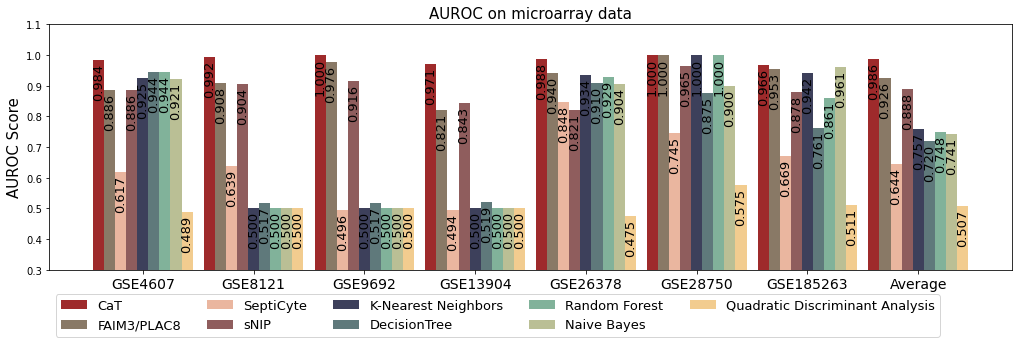

In [13]:
x_train = np.append(np.append(data[0], data[1], axis=0),data[2], axis=0)
y_train = np.append(np.append(label[0],label[1], axis=0),label[2], axis=0)
file_train = ["95233","26440","57065"]
save_name = "95233+26440+57065"

org_model = loadmodel()
model = transfer(org_model,x_train,y_train)
# model = keras.models.load_model("./model/transferred_model")
results = pd.DataFrame(columns = ['Cohort','AUC','Model'])

# test CapTrans
for x_test,y_test,file_test in zip(data[3:],label[3:],files[3:]):
        testresult=model.predict(x_test)
        fpr, tpr, _ = roc_curve(y_test,testresult)
        roc_auc = auc(fpr,tpr)
        print(roc_auc)
        results = results.append({'Cohort':'GSE'+file_test,'AUC':roc_auc,'Model':'CaT'},ignore_index=True)

        
# compare to SOTA
results = pd.concat([results,sota],ignore_index=True)
results = pd.concat([results,sota2],ignore_index=True)

# compare to other ML
for name,clf_ in zip(names,classifiers):
        clf_.fit(x_train, y_train)
        for x_test,y_test,file_test in zip(data[3:],label[3:],files[3:]):
            predt = clf_.predict(x_test)
            fpr, tpr, _ = roc_curve(y_test,predt)
            roc_auc = auc(fpr,tpr)
            results = results.append({'Cohort':'GSE'+file_test,'AUC':roc_auc,'Model':name},ignore_index=True)

            
            
seq_train,seq_val, seqlabel_train,seqlabel_val = train_test_split(seq1,seq1_label,test_size=0.7,random_state=42)
file_train = ["185263"]
save_name = "185263"

org_model = loadmodel()
model = transfer(org_model,seq_train,seqlabel_train)
# model = keras.models.load_model("./model/transferred_model")

# test CapTrans
testresult=model.predict(seq_val)
fpr, tpr, _ = roc_curve(seqlabel_val,testresult)
roc_auc = auc(fpr,tpr)
print(roc_auc)
results = results.append({'Cohort':'GSE'+'185263','AUC':roc_auc,'Model':'CaT'},ignore_index=True)

for name,clf_ in zip(names,classifiers):
        clf_.fit(seq_train, seqlabel_train)
        
        predt = clf_.predict(seq_val)
        fpr, tpr, _ = roc_curve(seqlabel_val,predt)
        roc_auc = auc(fpr,tpr)
        results = results.append({'Cohort':'GSE'+'185263','AUC':roc_auc,'Model':name},ignore_index=True)
            
roc2 = results
for mod in roc2['Model'].unique().tolist():
        average = roc2[roc2['Model'] == mod]['AUC'].mean()
        roc2 = roc2.append({'Cohort':'Average','AUC':average,'Model':mod},ignore_index=True)
drawML(roc2,save_name)